## Notebook Purpose

Quantitative evaluation of qdess recon experiments

In [493]:
import os, sys
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.gridspec as gridspec
import numpy as np
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, norm_imgs

### apply stretch factor to images

- 0.8/(160/512) = 2.56 stretch factor
    - 0.8 = slice thickness, 160 = FOV in phase encode direction and 512 = number of kspace samples in the phase direction
        - FOV: distance over which an MR image is acquired or displayed
- qdess data in shape [nc, kx, ky, kz] = [16, 512, 512, 160] 
    - take central slice in kx. then undersample in [ky, kz]
    - in-plane voxels [kx, ky] are taken at 0.3mm x 0.3mm and thru-plane voxels are taken at spacing of 0.8mm
        - here "in-plane" refers to the sagittal plane, even though we are sampling in [ky,kz] and hence viewing axial images

if we want to view each true voxel equally...

### TODO: reason through this using FOV and k-space notes in g doc

In [475]:
def load_qdess_baseline(mtr_id, idx_kx=None):
    ''' given mtr_id e.g. MTR_123, load from pre-defined directory
              idx_kx: index in kx at which to get axial slice 
        loads .npy file of shape (x,y,z,1,2) 
        returns array of shape (y,z) '''
    
    arr = torch.from_numpy(np.load('{}MTR_{}.npy'.format(path_baseline, mtr_id))) # shape (x,y,z,1,2)
    
    if not idx_kx: # get central slice if unspecified
        idx_kx = arr.shape[0] // 2
    arr = arr[int(idx_kx), :, :, :, :]
    
    # combine real/complex values
    arr_new = torch.empty((arr.shape[0], arr.shape[1]), dtype=torch.complex64)
    arr_new.real = arr[:, :, 0, 0]
    arr_new.imag = arr[:, :, 0, 1]
    
    return np.array(torch.absolute(arr_new))

def crop_im_list(im_list, y0, x0, size):
    ''' crop each image in list to square of length size at (x0,y0) 
    
        (x,y) = (100,100) gives something 2.56x wider than it is tall
        (x,y) = (512, 160) gives something .8x wider than it is tall
        thus want a ratio of 2.56 / .8 = 3.2 '''
    
    R = 3.2
    
    im_list_crop = []
    for im in im_list:
        im_list_crop.append(im[x0:x0+int(R*size), y0:y0+size])
    return im_list_crop

### define test set

based off `/bmrNAS/people/arjun/data/stanford-qDESS/annotations/v0.0.2/splits.xlsx`, which has pathology-relevant samples `MTR_065` and `MTR_066` in its test set

In [135]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'

MTR_ID_LIST = ['065', '066', '240', '156', '188', '199', '224', '198', '219', '096', '052', '196', '221', '241', '223', '178', '227', '099', '218', '248', '006', '005', '173', '048', '158', '080', '034', '144', '176', '244', '120', '235', '237', '030']
# fn_list = ['MTR_{}.h5'.format(f) for f in mtr_list]

# skip these samples b/c baselines have the incorrect dimensions
MTR_IDS_TO_SKIP = ['178', '223'] 
[MTR_ID_LIST.remove(mtr_id) for mtr_id in MTR_IDS_TO_SKIP]

[None, None]

In [487]:
ACCEL = 4

if ACCEL == 4:
    path_baseline = '/bmrNAS/people/arjun/results/mtr/toy/recon_only/version_004/test_results/stanford_qdess_v0.0.2_test/'
if ACCEL == 8:
    path_baseline = '/bmrNAS/people/arjun/results/mtr/recon/8x_toy/version_001/test_results/stanford_qdess_v0.0.2_test/'
    
path_recons = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo1/'.format(ACCEL)

In [488]:
NUM_SAMPS = len(MTR_ID_LIST)
NUM_VARS = 3 # ground-truth, our output, original baseline
NUM_METRICS = 4 # vif, msssim, ssim, psnr

im_list = np.empty((NUM_SAMPS, NUM_VARS, 512, 160))
metric_dc_list = np.empty((NUM_SAMPS, NUM_METRICS))
metric_bl_list = np.empty((NUM_SAMPS, NUM_METRICS))

for idx, mtr_id in enumerate(MTR_ID_LIST):

    img_gt = np.load('{}MTR_{}_gt.npy'.format(path_recons, mtr_id))
    img_dc = np.load('{}MTR_{}_dc.npy'.format(path_recons, mtr_id))
    img_bl = load_qdess_baseline(mtr_id)
    
    img_gt, img_dc = norm_imgs(img_gt, img_dc)
    img_gt, img_bl = norm_imgs(img_gt, img_bl)
        
    metric_dc_list[idx] = calc_metrics(img_gt, img_dc, imgs_already_normed=True)
    metric_bl_list[idx] = calc_metrics(img_gt, img_bl, imgs_already_normed=True)
    im_list[idx] = [img_gt, img_dc, img_bl]

print('dd+')
print(np.mean(metric_dc_list, axis=0))
print(np.std(metric_dc_list, axis=0))

print('\nu-net')
print(np.mean(metric_bl_list, axis=0))
print(np.std(metric_bl_list, axis=0))

dd+
[ 0.90623197  0.97175826  0.87102744 33.00638277]
[0.0184051  0.00664375 0.02311126 1.27135268]

u-net
[ 0.86974168  0.97289299  0.87535098 32.56962   ]
[0.02184523 0.00902151 0.02416184 1.54293782]


In [489]:
im_list_4x = im_list
# im_list_8x = im_list

##### results as of 20201209, 4x

dd+
[ 0.90623197  0.97175826  0.87102744 33.00638277]
[0.0184051  0.00664375 0.02311126 1.27135268]

u-net
[ 0.86974168  0.97289299  0.87535098 32.56962   ]
[0.02184523 0.00902151 0.02416184 1.54293782]

##### results as of 20201212, 8x
dd+
[ 0.85231291  0.95971144  0.82288653 30.53307349]
[0.02857065 0.00957325 0.0320011  1.19964968]

u-net
[ 0.84892113  0.96859784  0.85352072 31.42043279]
[0.02615346 0.00945546 0.02712443 1.44689988]

### make difference maps w gt

In [8]:
im_diff_list = np.empty(im_list.shape)

for idx_s, samp in enumerate(im_list): # for each sample
    
    gt = samp[0]
    
    for idx_v, var in enumerate(samp): # for each variation of that sample
        
        if idx_v == 0:
            im_diff = np.zeros(gt.shape)
        else:
            im_diff = np.abs(var - gt)    
        
        im_diff_list[idx_s, idx_v]  = im_diff

In [502]:
IDX_OI = 6
MTR_ID_LIST[IDX_OI]

'224'

In [567]:
dict_inset_bbox = {'224': {'bbox': (49, 313, 37),
                           'inset': (80, 40, 60)}}

(49, 313, 37)

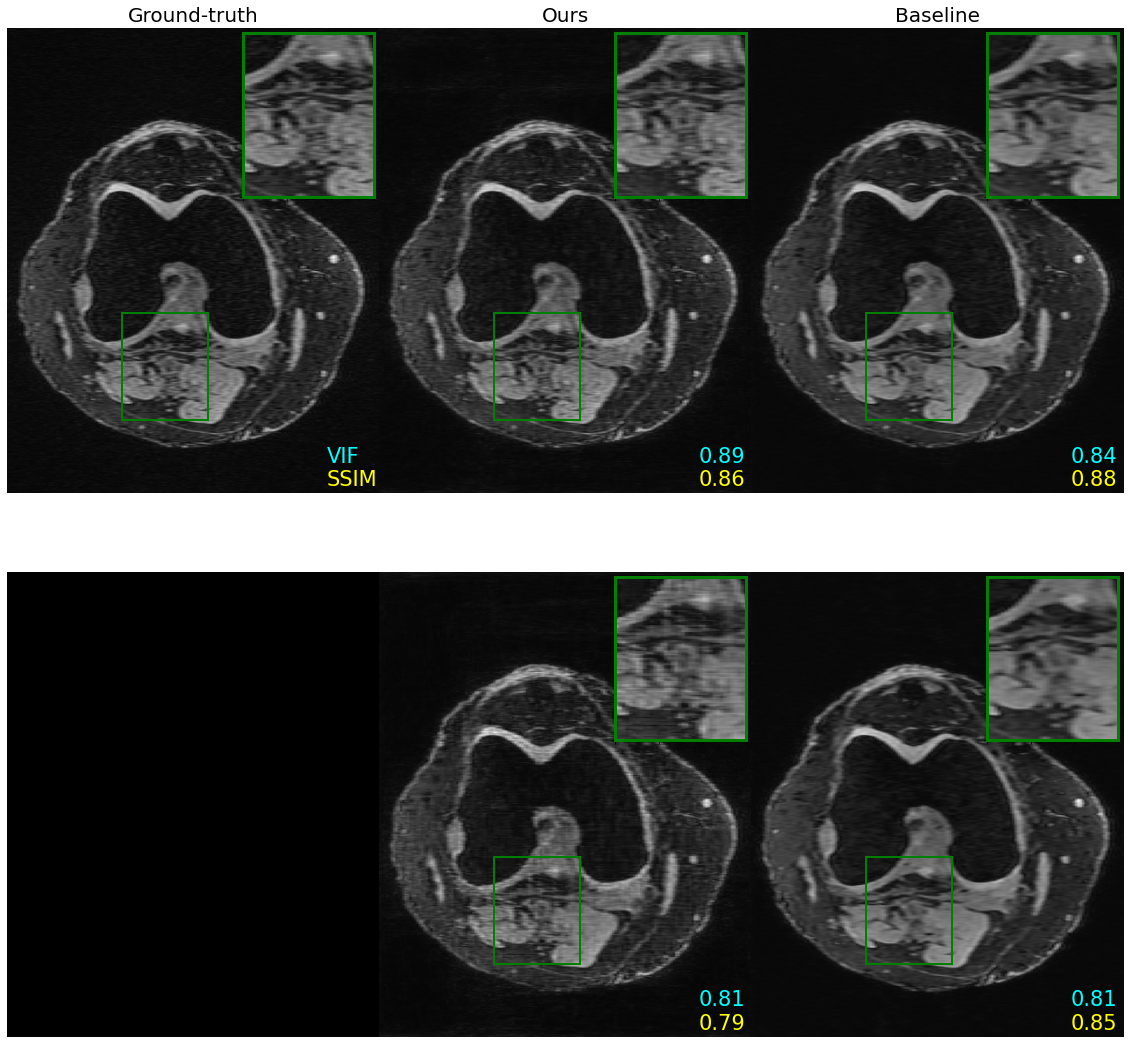

In [613]:
# plot_list_many_rows(np.array([[im_list_4_8[0][0]]]), bbox =(49, 313, 37))
plot_list_many_rows(im_list_4_8, bbox=True, inset=True)

In [612]:
def plot_list_many_rows(arr_list, clim=(0,.1), bbox=False, display_scores=True, inset=False):
    ''' given list of arrays arr_list, plot 
        dimns of arr_list (rows, cols, x, y) 
                 e.g. (3,4,x,y) would plot 3 rows of 4 cols '''
    
    SF = 2.56 # stretch factor 
    R = 3.2 # get same height:width ratio when (512,160) is stretched 2.56
    
    assert arr_list.ndim == 4
    
    NUM_ROWS, NUM_COLS = arr_list.shape[0], arr_list.shape[1]
    NUM_SAMPS = NUM_COLS * NUM_ROWS
    title_list = ['Ground-truth', 'Ours', 'Baseline'] # across rows
    im_gt = arr_list[0][0]
    IM_SIZE = im_gt.shape
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(NUM_ROWS,NUM_COLS)
    gs.update(wspace=0, hspace=0)
    
    for idx in range(NUM_SAMPS):
        ax = plt.subplot(gs[idx])
        
        idx_row, idx_col = idx // NUM_COLS, idx % NUM_COLS
        if idx_col == 0 and idx_row != 0:
            im = np.zeros((IM_SIZE))
            bbox_ = False
        else:
            im = arr_list[idx_row, idx_col]
            bbox_ = bbox
        
        if bbox_:
            y0, x0, size = dict_inset_bbox['224']['bbox']
            rect = patches.Rectangle((y0,x0),size,int(R*size),linewidth=2,edgecolor='g',facecolor='none')
            ax.add_patch(rect)

        if display_scores:
            if idx_col == 0:
                if idx == 0:
                    textstr_1, textstr_2 = 'VIF', 'SSIM'
                else:
                    textstr_1, textstr_2 = '', ''
            else:
                im_dc = im
                metrics = calc_metrics(im_gt, im_dc)
                textstr_1, textstr_2 = str(np.round(metrics[0], 2)), str(np.round(metrics[2], 2))
                
            ax.text(0.86, 0.1, textstr_1, transform=ax.transAxes, fontsize=21,
                    verticalalignment='top', color='cyan')
            ax.text(0.86, 0.05, textstr_2, transform=ax.transAxes, fontsize=21,
                    verticalalignment='top', color='yellow')
            
        ax.imshow(im, cmap='gray', clim=clim, aspect=(1./SF))
                    
        if inset:            
            axins = zoomed_inset_axes(ax, zoom=3, loc=1)
            EXTENT = 256 # 256 works
            axins.imshow(im, cmap='gray', clim=clim, extent=[0,EXTENT,0,EXTENT], aspect=1/0.8)
            
            # origin for inset is lower left
            x0, y0, size = dict_inset_bbox['224']['inset']
            
            axins.set_anchor('NE')#, axins.axis('off')
            if idx_col == 0 and idx != 0:
                axins.axis('off')
            else:
                plt.rcParams["axes.edgecolor"] = 'green'
                plt.rcParams["axes.linewidth"]  = 3
            axins.set_xlim(x0, x0+size) # axes origin at upper left
            axins.set_ylim(y0, y0+size)
            plt.xticks(visible=False), plt.yticks(visible=False)
            

        if idx_row == 0:
            ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')